In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.linalg import sqrtm

%matplotlib inline

In [2]:
args = {
    'num_clusters': 8,
    'num_eigen_vectors': 3,
    'sigma_color': 0.4,
    'sigma_distance': 5,
    'height': 100,
    'width': 100,
    'num_channels': 0,
    'num_dimensions': 0,
    'num_elements_flat': 0,
    'use_numpy_eigen_decompose': True,
    'dim_low': 50
}

# data_dir = os.path.join('..', 'data')
# image_dir = os.path.join(data_dir, 'idd20k_lite', 'leftImg8bit', 'train', '1')
# filename = '502201_image.jpg'
# image_path_full = os.path.join(image_dir, filename)
# image = cv2.imread(image_path_full)

image = cv2.imread('bw.jpg')
# image = cv2.imread('vegetables.png')


image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB
# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # convert to Grayscale
# image = cv2.resize(image, (args['height'], args['width']))



image_shape = len(image.shape)
if image_shape == 3:
    height, width, num_channels = image.shape
elif image_shape == 2:
    height, width = image.shape
    num_channels = 1
    
args['height'] = height
args['width'] = width
args['num_channels'] = num_channels
args['num_elements_flat'] = height * width
args['num_dimensions'] = num_channels + 2

In [4]:
def visualize_matrix(matrix, title=''):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.imshow(matrix)
    plt.colorbar()
    plt.show()


def imshow(image, title=''):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.imshow(image)
    plt.show()


def get_image_array(image):
    image_array = np.zeros((args['num_elements_flat'], (args['num_channels'] + 2)))

    image_array_index = 0
    for index_row in range(args['height']):
        for index_col in range(args['width']):
            current_pixel = image[index_row, index_col]
            image_array[image_array_index] = np.array([current_pixel[0],
                                                       current_pixel[1],
                                                       current_pixel[2],
                                                       index_row,
                                                       index_col])
            image_array_index += 1

    return image_array


def get_exponential_bump(distance, sigma=1):
    exponential_bump = np.exp(-np.abs(distance) / sigma ** 2)
    return exponential_bump

def get_eucledian_distance_vectorized(point_1, point_2_array):
    euclidean_distance = np.sqrt(np.sum(np.power((point_1 - point_2_array), 2), axis=1))
    return euclidean_distance

def get_color_weight_vectorized(point_1, point_2_array, sigma_color):
    point_1 = point_1.reshape(-1, point_2_array.shape[1])
    point_2_array = point_2_array.reshape(-1, point_2_array.shape[1])
    difference_color = get_eucledian_distance_vectorized(point_1, point_2_array)
    color_weight = get_exponential_bump(difference_color, sigma_color)
    return color_weight

def get_distance_weight_vectorized(point_1, point_2_array, sigma_distance):
    point_1 = point_1.reshape(-1, point_2_array.shape[1])
    point_2_array = point_2_array.reshape(-1, point_2_array.shape[1])
    distance = get_eucledian_distance_vectorized(point_1, point_2_array)
    distance_weight = get_exponential_bump(distance, sigma_distance)
    return distance_weight



# def get_weight_matrix(image_array):
#     weight_matrix = np.zeros((args['num_elements_flat'], args['num_elements_flat']))
#     dim_low = args['dim_low']

#     # using Nystrom
#     for index_1 in tqdm(range(args['num_elements_flat'])):
#         if index_1 == dim_low:
#             break
#         for index_2 in range(args['num_elements_flat']):
#             if index_1 == index_2:
#                 weight_matrix[index_1, index_2] = 0
#             point_1 = image_array[index_1]
#             point_2 = image_array[index_2]

#             weight_color = get_color_weight(point_1[:args['num_channels']], point_2[:args['num_channels']],
#                                             args['sigma_color'])
#             weight_distance = get_distance_weight(point_1[-2], point_1[-1], point_2[-2], point_2[-1],
#                                                   args['sigma_distance'])

#             weight_matrix[index_1, index_2] = weight_color * weight_distance

#     # assume weight_matrix = [A    B]
#     #                        [B.T  C]

#     # calculate the partitions
#     A = weight_matrix[:dim_low, :dim_low]  # mxm
#     B = weight_matrix[:dim_low, dim_low:]  # mxn
#     C = B.T @ np.linalg.pinv(A) @ B  # nxm @ mxm @ mxn = nxn

#     # combine the partitions
#     weight_matrix[dim_low:, :dim_low] = B.T  # nxm
#     weight_matrix[dim_low:, dim_low:] = C  # nxn

#     # set all the values of the diagonal to 0
#     np.fill_diagonal(weight_matrix, 0)

#     # slow version, using functions
#     #     # needs fixing
#     #     for index_1 in tqdm(range(args['num_elements_flat'])):
#     #         for index_2 in range(args['num_elements_flat']):
#     #             if index_1 == index_2:
#     #                 continue
#     #             point_1 = image_array[index_1]
#     #             point_2 = image_array[index_2]

#     #             weight_color = get_color_weight(point_1[:args['num_channels']], point_2[:args['num_channels']], args['sigma_color'])
#     #             weight_distance = get_distance_weight(point_1[-2], point_1[-1], point_2[-2], point_2[-1], args['sigma_distance'])

#     #             weight_matrix[index_1, index_2] = weight_color * weight_distance
#     return weight_matrix


# def get_degree_matrix(weight_matrix):
#     # returns a vector of diagonal components instead of a diagonal matrix
#     degree_matrix = np.sum(weight_matrix, axis=1)
#     return degree_matrix


# def get_laplacian_matrix(weight_matrix, degree_matrix):
#     degree_neg_half = np.diag(np.power(degree_matrix, -0.5))
#     degree_matrix = np.diag(degree_matrix)
#     laplacian_matrix = degree_neg_half @ (degree_matrix - weight_matrix) @ degree_neg_half
#     return laplacian_matrix


# def eigen_decompose(matrix):
#     # returns eigen values and eigen vectors sorted in ascending order
#     if args['use_numpy_eigen_decompose']:
#         eigen_vals, eigen_vecs = np.linalg.eigh(matrix)
#         index_sorted = np.argsort(eigen_vals)
#         eigen_vals = eigen_vals[index_sorted]
#         eigen_vecs = eigen_vecs[index_sorted]

#     return eigen_vals, eigen_vecs


# def get_k_eigen_vectors(eigen_vecs):
#     eigen_vecs = eigen_vecs[:, 1:args['num_eigen_vectors'] + 1]
#     return eigen_vecs


# def plot_eigen_values(eigen_vals):
#     num_elements = len(eigen_vals)
#     x = np.arange(0, num_elements, 1)
#     plt.figure(figsize=(5, 5))
#     plt.plot(x, eigen_vals, label='Eigen Values (Ascending order)')
#     plt.legend()
#     plt.show()


# def get_eigen_map(eigen_vals):
#     num_elements = len(eigen_vals)
#     eigen_map = np.zeros(num_elements)

#     for index in range(1, num_elements):
#         eigen_map[index] = eigen_vals[index] - eigen_vals[index - 1]
#     return eigen_map


# def plot_eigen_map(eigen_vals):
#     eigen_map = get_eigen_map(eigen_vals)

#     num_elements = len(eigen_map)
#     x = np.arange(0, num_elements, 1)
#     plt.figure(figsize=(5, 5))
#     plt.plot(x, eigen_map, label='Eigen Map')
#     plt.legend()
#     plt.show()

def get_segmented_image(image, clustered_image, clustered_labels):
    '''
        abhi's color
    '''
    label_values = np.unique(clustered_labels)
    segmented_image = np.zeros_like(image)

    for index in label_values:
        current_mask = (clustered_image == index).astype(np.uint8)
        current_segment = image * np.repeat(current_mask[..., None], 3, axis=2)

        for channel_index in range(3):
            current_channel = current_segment[:, :, channel_index]
            cluster_total = np.count_nonzero(current_channel)
            cluster_sum = np.sum(current_channel)
            cluster_mean = cluster_sum / cluster_total
            current_segment[:, :, channel_index] = np.where(current_segment[:, :, channel_index] > 0, cluster_mean,
                                                            current_segment[:, :, channel_index])
            segmented_image[:, :, channel_index] += current_segment[:, :, channel_index].astype(np.uint8)

    return segmented_image

# def get_segmented_image(image, clustered_image, clustered_labels):
#     '''
#         sid's bw
#     '''
#     label_values = np.unique(clustered_labels)
#     segmented_image = np.zeros_like(image)
#     factor = 255 / (np.max(image) - np.min(image))
#     for index in label_values:
#         current_mask = (clustered_image == index).astype(np.uint8)
#         current_segment = factor * image * current_mask

#         cluster_total = np.count_nonzero(current_segment)
#         cluster_sum = np.sum(current_segment)
#         cluster_mean = cluster_sum / cluster_total
#         current_segment = np.where(current_segment > 0, cluster_mean, current_segment)
#         segmented_image += current_segment.astype(np.uint8)

#     return segmented_image


def get_k_eig_vectors_nystrom(image_array):
    dim_low = args['dim_low']
    weight_matrix = np.zeros((dim_low, args['num_elements_flat']))

    indices_low = np.random.choice(args['num_elements_flat'], size=dim_low, replace=False)
    image_low = image_array[indices_low]

    for index_1 in tqdm(range(len(image_low))):
        point_1 = image_low[index_1]
        weight_color = get_color_weight_vectorized(point_1[:args['num_channels']], image_array[:, :args['num_channels']], args['sigma_color'])
        weight_distance = get_distance_weight_vectorized(point_1[-2:], image_array[:, -2:], args['sigma_distance'])
        weight_matrix[index_1] = weight_color * weight_distance
        weight_matrix[index_1, index_1] = 1

    A = weight_matrix[:, list(indices_low)]  # nxn
    B = np.delete(weight_matrix, list(indices_low), axis=1)  # nxm
    n, m = B.shape
    #     print(A.shape)
    #     print(B.shape)
    A_pinv = np.linalg.pinv(A)
    d1 = np.sum(np.vstack((A, B.T)), axis=0).reshape(1, -1)
    d2 = np.sum(B, axis=0) + (np.sum(B.T, axis=0).reshape(1, -1) @ (A_pinv @ B))
    print(d1.shape)
    print(d2.shape)
    dhat = np.sqrt(1 / np.hstack((d1, d2))).reshape(-1, 1)
    print(dhat.shape)
    print(np.count_nonzero(np.argwhere(d2 < 0)))
    A = A * (dhat[:n].reshape(-1, 1) @ dhat[:n].reshape(-1, 1).T)
    B = B * (dhat[:n].reshape(-1, 1) @ dhat[n:].reshape(-1, 1).T)

    pinv_A = np.linalg.pinv(A)

    Asi = sqrtm(pinv_A)

    Q = A + Asi @ B @ B.T @ Asi
    U, L, T = np.linalg.svd(Q)

    L = np.diag(L)

    V = np.hstack((A, B)).T @ Asi @ U @ np.linalg.pinv(np.sqrt(L))

    V = V[:, 1:args['num_eigen_vectors'] + 1]
    # reordering V appropriately
    all_idx = list(np.arange(args['num_elements_flat']))
    rem_idx = [idx for idx in all_idx if idx not in indices_low]
    top_matrix = np.zeros((args['num_elements_flat'], args['num_eigen_vectors']))
    top_matrix[list(indices_low), :] = V[:dim_low, :]
    top_matrix[rem_idx, :] = V[dim_low:, :]
    return top_matrix

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.04it/s]


(1, 50)
(1, 1036750)
(1036800, 1)
0
(1036800, 3)


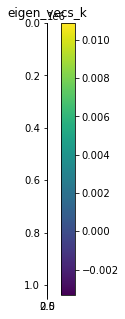

(1036800,)


<ipython-input-4-ef0ef0b0176c>:181: RuntimeWarning: invalid value encountered in true_divide
  cluster_mean = cluster_sum / cluster_total


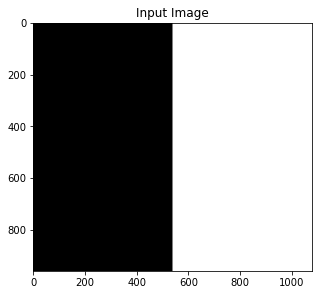

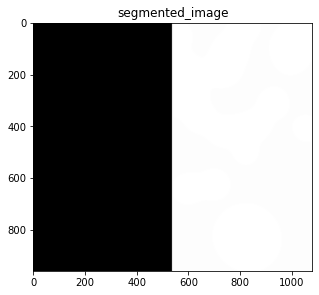

In [5]:
image_array = get_image_array(image)
eigen_vecs_k = get_k_eig_vectors_nystrom(image_array)
print(eigen_vecs_k.shape)

visualize_matrix(eigen_vecs_k, 'eigen_vecs_k')

kmeans = KMeans(n_clusters=args['num_clusters'], random_state=0).fit(eigen_vecs_k)
clustered_labels = kmeans.labels_
print(clustered_labels.shape)
clustered_image = clustered_labels.reshape(args['height'], args['width'])

# segment the image using average color for each cluster
segmented_image = get_segmented_image(image, clustered_image, clustered_labels)

imshow(image, 'Input Image')
# imshow(clustered_image, 'Clustered Image')
imshow(segmented_image, 'segmented_image')

In [ ]:
imshow(image, 'Input Image')

image_array = get_image_array(image)
weight_matrix = get_weight_matrix(image_array)
degree_matrix = get_degree_matrix(weight_matrix)
laplacian_matrix = get_laplacian_matrix(weight_matrix, degree_matrix)

eigen_vals, eigen_vecs = eigen_decompose(laplacian_matrix)
eigen_vecs_k = get_k_eigen_vectors(eigen_vecs)
(print(eigen_vecs_k.shape))

# visualize_matrix(weight_matrix, 'weight_matrix')
# visualize_matrix(np.diag(degree_matrix), 'degree_matrix')
# visualize_matrix(laplacian_matrix, 'laplacian_matrix')
# visualize_matrix(np.diag(eigen_vals), 'eigen_vals')
# visualize_matrix(eigen_vecs, 'eigen_vecs')
# visualize_matrix(eigen_vecs_k, 'eigen_vecs_k')
# plot_eigen_values(eigen_vals)
# plot_eigen_map(eigen_vals)




kmeans = KMeans(n_clusters=args['num_clusters'], random_state=0).fit(eigen_vecs_k)
clustered_labels = kmeans.labels_
print(clustered_labels.shape)
clustered_image = clustered_labels.reshape(args['height'], args['width'])

# segment the image using average color for each cluster
segmented_image = get_segmented_image(image, clustered_image, clustered_labels)

imshow(image, 'Input Image')
# imshow(clustered_image, 'Clustered Image')
imshow(segmented_image, 'segmented_image')